In [1]:
from datasets import load_from_disk

# Specify the path to the dataset
dataset_path = '/data/lmm/generated/v3_spatial_grid_multimodal'

# Load the dataset
dataset = load_from_disk(dataset_path)

# Display the dataset
print(dataset)

/home/allanz/miniconda3/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 100000
    })
    validation: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 1000
    })
})


In [2]:
dataset["train"][0]

{'text': "| deer | cat | bird |\n| deer | cat | cat |\n| bird | dog | bird |\nThe grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].\nWhat object is in row 2, column 2? A: bird\nWhat object is in row 1, column 2? A: cat\nWhat object is in row 0, column 0? A: deer\nWhat object is in row 0, column 1? A: cat\nWhat object is in row 1, column 0? A: deer\nWhat object is in row 1, column 1? A: cat\nWhat object is in row 0, column 2? A: bird\nWhat object is in row 2, column 1? A: dog\nWhat object is in row 2, column 0? A: bird",
 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].",
 'conversations': [['What object is in row 2, column 2?', 'A: bird'],
  ['What object is in row 1, column 2?', 'A: cat'],
  ['What object is in row 0, column 0?', 'A: deer'],
  ['What object is in row 0, column 1?', 'A: cat'],
  ['What object is in row 1, column 0?', 'A: deer'],
  ['What object is in row 1, column 1?',

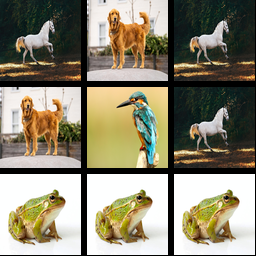

The grid above is size 3 by 3. Each cell contains an object from ['bird', 'horse', 'dog', 'frog'].
What object is in row 2, column 0?
A: frog
What object is in row 0, column 2?
A: horse
What object is in row 0, column 1?
A: dog
What object is in row 0, column 0?
A: horse
What object is in row 2, column 2?
A: frog
What object is in row 1, column 2?
A: horse
What object is in row 2, column 1?
A: frog
What object is in row 1, column 0?
A: dog
What object is in row 1, column 1?
A: bird


In [3]:
import random 
from PIL import Image 

randint = random.randint(0, 1000)
display(Image.open(f"/data/lmm/generated/v3_spatial_grid_multimodal/images/train_{randint}.png"))
print(dataset['train'][randint]["prompt"])
for conv in dataset["train"][randint]["conversations"]:
    print(conv[0])
    print(conv[1])

In [5]:
import argparse
import json
import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_from_disk
from loguru import logger
from PIL import Image
from tqdm import tqdm
from transformers import AutoTokenizer, GPTJForCausalLM

In [ ]:
def load_model_and_tokenizer(model_path, multimodal=False):
    """
    Load the model and tokenizer from the specified path.
    """
    logger.info(f"Loading model and tokenizer from {model_path}")
    model, tokenizer = None, None
    if multimodal:
        model = GPTJ_VLM.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model.config.pretrained_lm_path)
    else:
        model = GPTJForCausalLM.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()
    return model, tokenizer